## Convex Hull :: Road Fitting

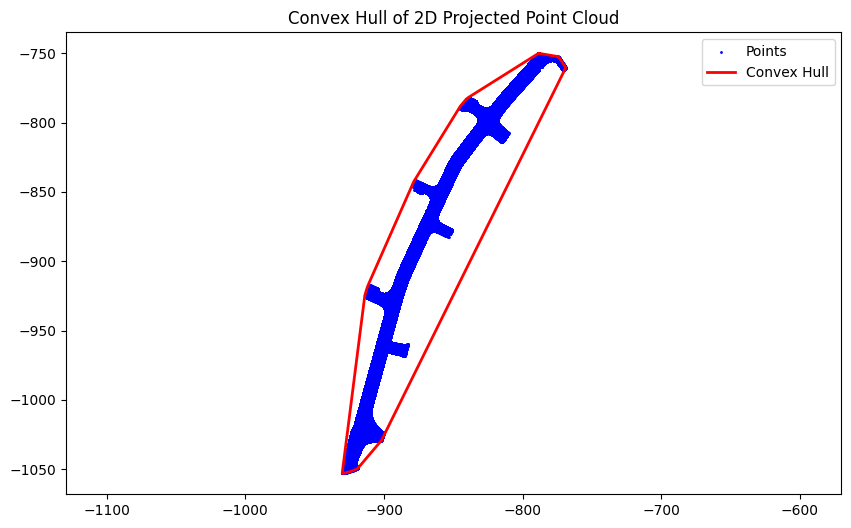

In [2]:
# ----------------------------------------------------------------------------------------------------||
# <Import Libraries>
# ----------------------------------------------------------------------------------------------------||
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull

# ----------------------------------------------------------------------------------------------------||
# <Load and Project Point Cloud>
# ----------------------------------------------------------------------------------------------------||
def loadAndProjectPLY(plyPath):
    cloud = pv.read(plyPath)
    points = np.array(cloud.points)
    points2D = points[:, :2]
    points2D = np.unique(points2D, axis=0)
    return points2D

# ----------------------------------------------------------------------------------------------------||
# <Compute and Plot Convex Hull>
# ----------------------------------------------------------------------------------------------------||
def plotConvexHull(points2D):
    hull = ConvexHull(points2D)
    hullPoints = points2D[hull.vertices]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(points2D[:, 0], points2D[:, 1], s=1, color='blue', label='Points')
    plt.plot(np.append(hullPoints[:, 0], hullPoints[0, 0]), 
             np.append(hullPoints[:, 1], hullPoints[0, 1]), 
             'r-', linewidth=2, label='Convex Hull')

    plt.title("Convex Hull of 2D Projected Point Cloud")
    plt.axis('equal')
    plt.legend()
    plt.show()

    return hullPoints  # optionally return hull boundary points

# ----------------------------------------------------------------------------------------------------||
# <Run Step>
# ----------------------------------------------------------------------------------------------------||
fileName = "Lille2"
plyPath = f"Input/{fileName}.ply"
points2D = loadAndProjectPLY(plyPath)
hullBoundary = plotConvexHull(points2D)

## Cocave Hull :: Road Fitting

In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

def loadAndProjectPLY(plyPath):
    cloud = pv.read(plyPath)
    points = np.array(cloud.points)
    points2D = points[:, :2]
    points2D = np.unique(points2D, axis=0)
    return points2D

In [2]:
fileName = "ParisLille_Combined_Road_Road1"
plyPath = f"Input/{fileName}.ply"
points2D = loadAndProjectPLY(plyPath)
# hullBoundary = plotOptimizedAlphaHull(points2D)

In [3]:
%%time

from concave_hull import concave_hull

# Compute concave hull
k = 10  # kNN based fitting :: 5-20 is common
#concave_hull(points, length_threshold=50))
hull = concave_hull(points2D.tolist(), length_threshold=k)

# Convert back to numpy for plotting
nhull = np.array(hull + [hull[0]])  # close the loop

CPU times: user 2d 11h 20min 4s, sys: 1h 18min 42s, total: 2d 12h 38min 47s
Wall time: 2d 12h 22min 53s


/home/gvcl/anaconda3/envs/digTwin/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


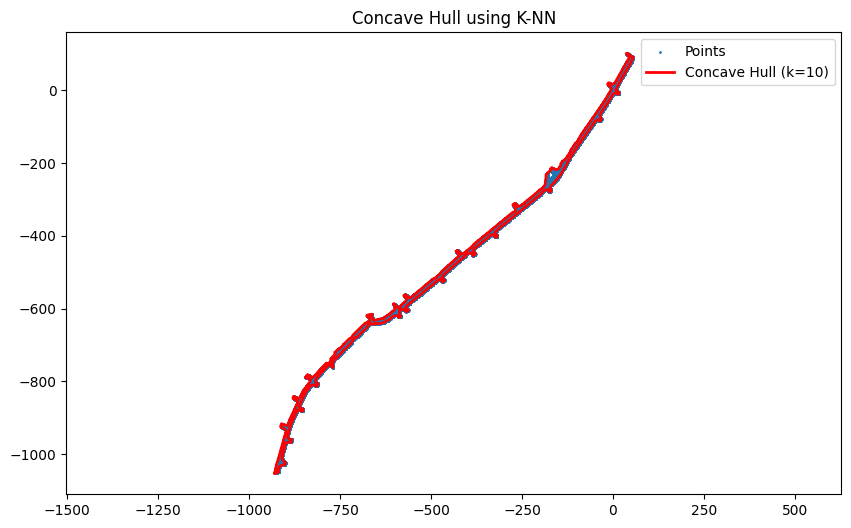

In [4]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(points2D[:, 0], points2D[:, 1], s=1, label='Points')
plt.plot(nhull[:, 0], nhull[:, 1], 'r-', linewidth=2, label=f'Concave Hull (k={k})')
plt.axis('equal')
plt.title("Concave Hull using K-NN")
plt.legend()
plt.show()

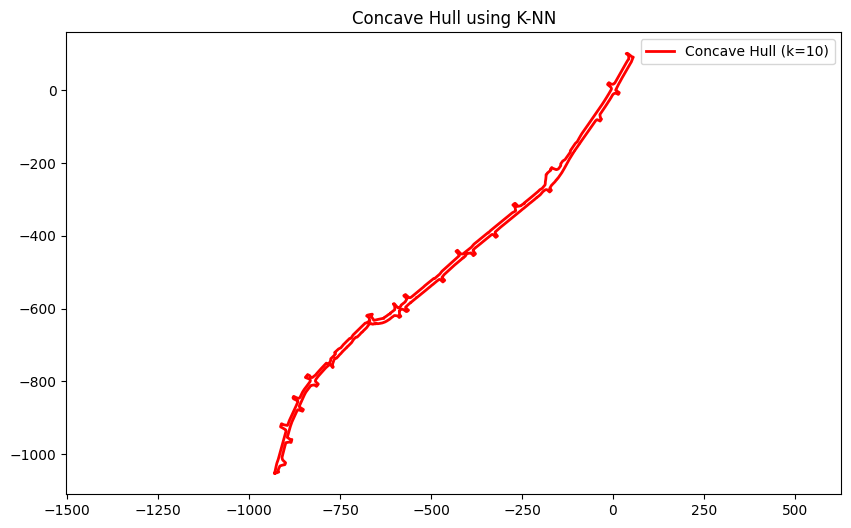

In [5]:
# Plot
plt.figure(figsize=(10, 6))
#plt.scatter(points2D[:, 0], points2D[:, 1], s=1, label='Points')
plt.plot(nhull[:, 0], nhull[:, 1], 'r-', linewidth=2, label=f'Concave Hull (k={k})')
plt.axis('equal')
plt.title("Concave Hull using K-NN")
plt.legend()
plt.show()

In [6]:
nhull

array([[ -930.13708496, -1052.64990234],
       [ -930.1361084 , -1052.57666016],
       [ -930.08319092, -1052.49841309],
       ...,
       [ -929.52288818, -1052.95532227],
       [ -930.12506104, -1052.96508789],
       [ -930.13708496, -1052.64990234]], shape=(38390, 2))

In [7]:
#--------------------------------------------------------------------------------------------<Save the data>-----------------||
import pickle

with open(f"Extraction/{fileName}.pkl", "wb") as f:
    pickle.dump(nhull, f)

print("Saved pkl files to disk.")

Saved pkl files to disk.


In [8]:
# ----------------------------------------------------------------------------------------------------||
# <Save Hull and Closed Hull to Disk>
# ----------------------------------------------------------------------------------------------------||
np.save(f"Extraction/{fileName}_hull.npy", np.array(hull))       # raw ordered hull
np.save(f"Extraction/{fileName}_nhull.npy", nhull)               # closed-loop hull
np.save(f"Extraction/{fileName}_points2D.npy", points2D)         # points

## Vornoi diagram :: Used to extract the medial axis

In [1]:
"""
from datetime import datetime
import time

current_datetime = datetime.now()
print(f"Current datetime object: {current_datetime}")
"""

Current datetime object: 2025-07-22 16:16:08.444611


In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from concave_hull import concave_hull

fileName = "Lille2"

In [2]:
%%time 
#START RUNNING AROUND 3:56PM

# ----------------------------------------------------------------------------------------------------||
# <Import libraries for centerline extraction>
# ----------------------------------------------------------------------------------------------------||
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, LineString

# ----------------------------------------------------------------------------------------------------||
# <Load hull and points>
# ----------------------------------------------------------------------------------------------------||
points2D = np.load(f"Extraction/{fileName}_points2D.npy")  # Save this if not already
hull = np.load(f"Extraction/{fileName}_hull.npy", allow_pickle=True)
nhull = np.load(f"Extraction/{fileName}_nhull.npy")

boundaryPolygon = Polygon(hull.tolist())

CPU times: user 1.89 s, sys: 64.2 ms, total: 1.95 s
Wall time: 448 ms


In [3]:
%%time 

# ----------------------------------------------------------------------------------------------------||
# <Compute Voronoi diagram and filter edges inside concave hull>
# ----------------------------------------------------------------------------------------------------||
vor = Voronoi(points2D)
centerlines = []

for ridge in vor.ridge_vertices:
    if -1 in ridge:
        continue  # skip infinite edges

    p1, p2 = vor.vertices[ridge]
    edge = LineString([p1, p2])
    if boundaryPolygon.contains(edge):
        centerlines.append(edge)


In [5]:
import pickle

centerlines
np.save(f"Extraction/{fileName}_centerlines.npy", centerlines)    

with open(f"Extraction/{fileName}_centerlines.pkl", "wb") as f:
    pickle.dump(centerlines, f)

### START FROM HERE, ONCE ITS DONE

In [3]:
import pickle
#allow_pickle = True
#with open(f"Extraction/{fileName}_centerlines.pkl", "wb") as f:
#    pickle.dump(X_train, f)
centerlines = None
with open(f"Extraction/{fileName}_centerlines.pkl", "rb") as f:
        centerlines = pickle.load(f)

In [5]:
len(centerlines)

35394414

In [15]:
"""DOWNSAMPLING INORDER TO RETAIN THE RELEVANT ONES"""

from shapely.geometry import LineString, MultiLineString

# Filter: keep only LineStrings longer than 1.0
filtered_centerlines = []
for geom in centerlines:
    if isinstance(geom, LineString) and geom.length > 0.2:
        filtered_centerlines.append(geom)
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            if line.length > 1.0:
                filtered_centerlines.append(line)

print("Filtered count:", len(filtered_centerlines))

Filtered count: 2036


In [16]:
print(filtered_centerlines[0])    # Preview one line

2036
LINESTRING (-927.2820071659212 -1052.4201888376147, -926.9926576722667 -1052.3432059448076)


In [10]:
#print("points2D range:")
##print("  Y:", np.min(points2D[:, 1]), "to", np.max(points2D[:, 1]))

points2D range:
  X: -930.1371 to -768.98224
  Y: -1052.9651 to -750.0233


### <span style="color:blue">Green ones are the line segments</span>

/tmp/ipykernel_428115/2346385538.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


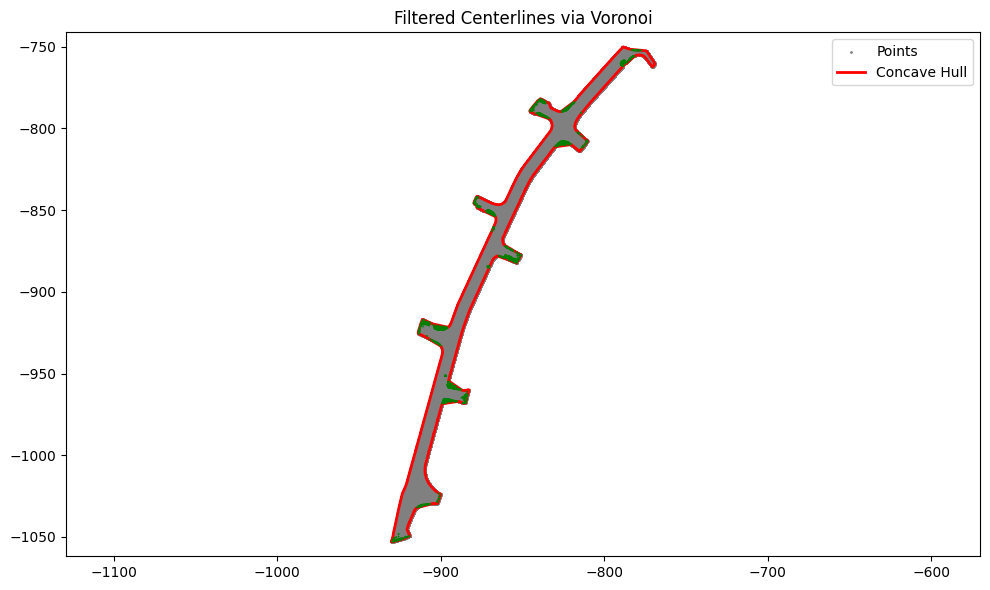

In [17]:
# ----------------------------------------------------------------------------------------------------||
# <Plot Filtered Centerlines>
# ----------------------------------------------------------------------------------------------------||
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(points2D[:, 0], points2D[:, 1], s=1, color='gray', label='Points')
plt.plot(nhull[:, 0], nhull[:, 1], 'r-', linewidth=2, label='Concave Hull')

# Plot filtered only
for line in filtered_centerlines:
    x, y = line.xy
    plt.plot(x, y, 'g-', linewidth=1)

plt.axis('equal')
plt.title("Filtered Centerlines via Voronoi")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
"""
SINCE THIS PARTICULAR METHOD WASN'T EFFECTIVE IN EXTRACTING THE MEDIAL AXIS, LETS LOOK INTO SOME SKELETONIZATION TECHNIQUES
"""

"\nSINCE THIS PARTICULAR METHOD WASN'T EFFECTIVE IN EXTRACTING THE MEDIAL AXIS, LETS LOOK INTO SOME SKELETONIZATION TECHNIQUES\n"

## Skeletonization :: Using vectorization 

In [1]:
#!pip install ladybug-geometry-polyskel

In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from concave_hull import concave_hull
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, LineString

fileName = "Lille2"

points2D = np.load(f"Extraction/{fileName}_points2D.npy")  # Save this if not already
hull = np.load(f"Extraction/{fileName}_hull.npy", allow_pickle=True)
nhull = np.load(f"Extraction/{fileName}_nhull.npy")

#boundaryPolygon = Polygon(hull.tolist())

In [2]:
#!pip install scikit-image

In [3]:
from shapely.affinity import translate
from shapely.ops import transform
from skimage.draw import polygon2mask
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt
from skimage import img_as_ubyte

# Step 1: Build a shapely polygon from your concave hull
polygon = Polygon(nhull)  # assumes nhull is (N, 2) closed loop

# Step 2: Normalize to image space
minx, miny, maxx, maxy = polygon.bounds
scale = 1.0  # adjust for resolution
w = int(np.ceil((maxx - minx) * scale)) + 1
h = int(np.ceil((maxy - miny) * scale)) + 1

In [4]:
def to_pixel(x, y):
    return ((x - minx) * scale, (maxy - y) * scale)  # keep float precision

# Make sure the polygon is CCW
if not polygon.exterior.is_ccw:
    polygon = Polygon(polygon.exterior.coords[::-1])

polygon_pix = transform(lambda x, y: to_pixel(x, y), polygon)

# Rasterize with float coordinates
mask = polygon2mask((h, w), np.array(polygon_pix.exterior.coords))

# Step 4: Distance transform and skeletonize
distance = distance_transform_edt(mask)
skeleton = skeletonize(mask)

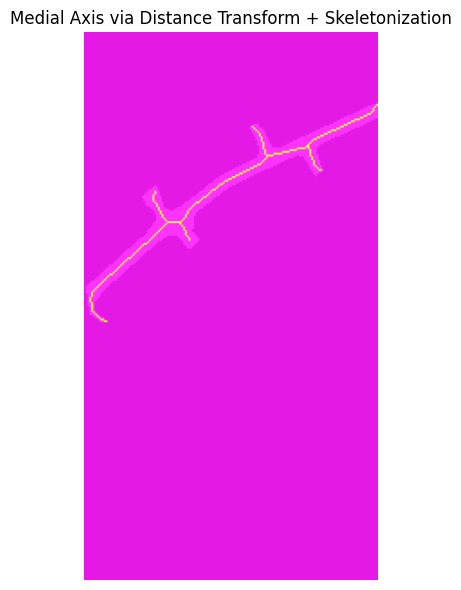

In [5]:
# Step 5: Visualize
plt.figure(figsize=(10, 6))
plt.imshow(mask, cmap='gray', alpha=0.5)
plt.imshow(skeleton, cmap='spring', alpha=0.8)
plt.title("Medial Axis via Distance Transform + Skeletonization")
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Real-world to pixel (used earlier)
# pixel_x = (real_x - minx) * scale
# pixel_y = (maxy - real_y) * scale

# Inverse: pixel to real-world
def pixel_to_real(x_pix, y_pix):
    real_x = x_pix / scale + minx
    real_y = maxy - y_pix / scale
    return real_x, real_y

In [7]:
from skimage.measure import find_contours
from shapely.geometry import LineString

# Extract skeleton contours (continuous paths) in pixel space
contours = find_contours(skeleton.astype(float), level=0.5)

# Convert contours back to real-world coordinates
real_lines = []

for contour in contours:
    coords = [pixel_to_real(x, y) for x, y in contour]  # note y,x order in image space
    if len(coords) > 1:
        real_lines.append(LineString(coords))

/home/gvcl/anaconda3/envs/digTwin/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


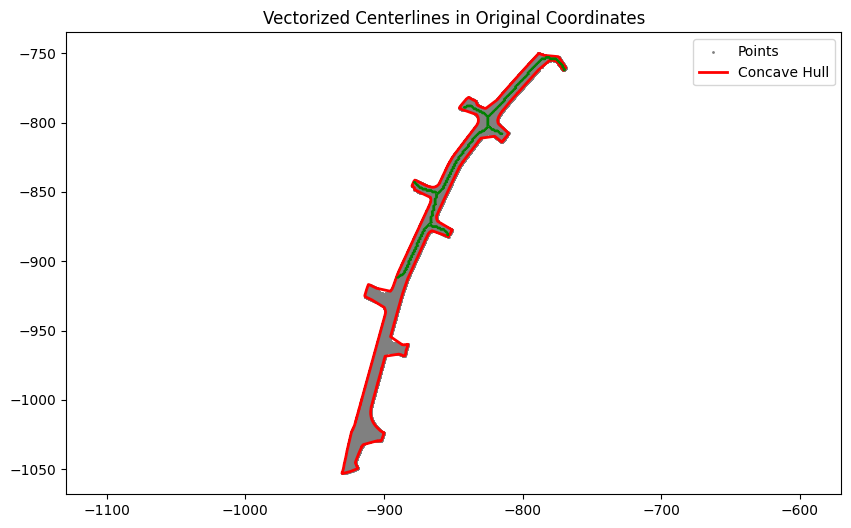

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(points2D[:, 0], points2D[:, 1], s=1, color='gray', label='Points')
plt.plot(nhull[:, 0], nhull[:, 1], 'r-', linewidth=2, label='Concave Hull')

for line in real_lines:
    x, y = line.xy
    plt.plot(x, y, 'g-', linewidth=1)

plt.axis('equal')
plt.title("Vectorized Centerlines in Original Coordinates")
plt.legend()
plt.show()

## Vornoi diagram based extraction - but keeping edges inside the polygon 

In [1]:
# ----------------------------------------------------------------------------------------------------||
# <Import libraries>
# ----------------------------------------------------------------------------------------------------||
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi

# ----------------------------------------------------------------------------------------------------||
# <Load input data>
# ----------------------------------------------------------------------------------------------------||
fileName = "ParisLille_Combined_Road_Road1" #"Lille2"

points2D = np.load(f"Extraction/{fileName}_points2D.npy")
hull = np.load(f"Extraction/{fileName}_hull.npy", allow_pickle=True)
nhull = np.load(f"Extraction/{fileName}_nhull.npy")

polygon = Polygon(nhull)

In [2]:
%%time

# Sample boundary points (denser = better medial axis)
num_samples = 1000
boundary = polygon.exterior
distances = np.linspace(0, boundary.length, num_samples)
sampled_pts = [boundary.interpolate(d).coords[0] for d in distances]
sampled_pts = np.array(sampled_pts)

# Voronoi from boundary samples
vor = Voronoi(sampled_pts)

CPU times: user 369 ms, sys: 4.22 ms, total: 373 ms
Wall time: 374 ms


In [3]:
%%time

# Extract medial axis: keep Voronoi edges fully inside polygon
medial_lines = []

for start, end in vor.ridge_vertices:
    if start == -1 or end == -1:
        continue
    p1 = vor.vertices[start]
    p2 = vor.vertices[end]
    line = LineString([p1, p2])
    if polygon.contains(line):
        medial_lines.append(line)

CPU times: user 654 ms, sys: 359 μs, total: 654 ms
Wall time: 654 ms


/home/gvcl/anaconda3/envs/digTwin/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


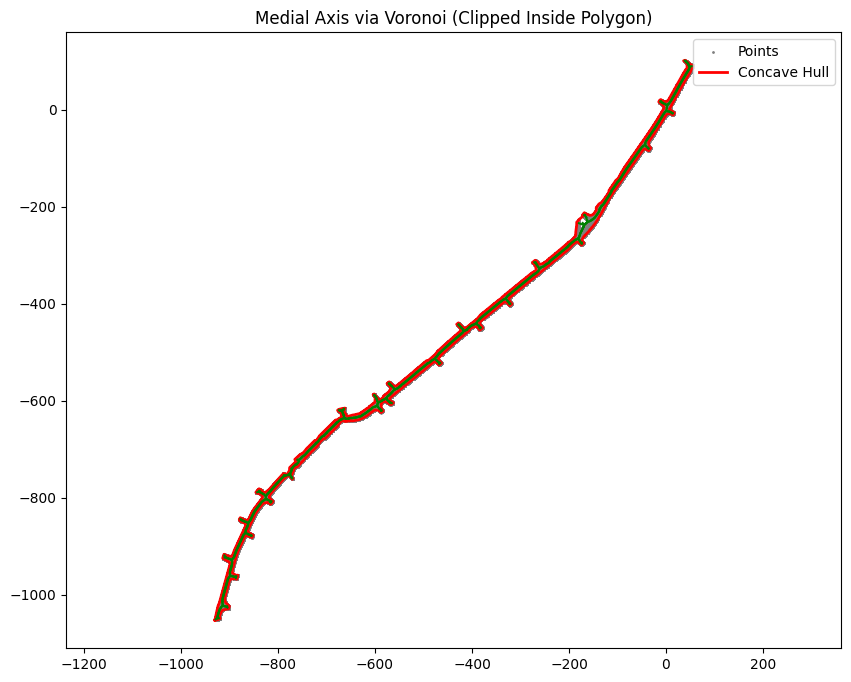

In [4]:
%%time

# Visualization
plt.figure(figsize=(10, 8))
# plt.plot(*polygon.exterior.xy, color='black', linewidth=2, label="Polygon")

plt.scatter(points2D[:, 0], points2D[:, 1], s=1, color='gray', label='Points')
plt.plot(nhull[:, 0], nhull[:, 1], 'r-', linewidth=2, label='Concave Hull')

for line in medial_lines:
    x, y = line.xy
    plt.plot(x, y, 'g-')
plt.axis('equal')
plt.title("Medial Axis via Voronoi (Clipped Inside Polygon)")
plt.legend()
plt.show()

In [5]:
import pickle

medial_lines
np.save(f"Extraction/{fileName}_centerlines.npy", medial_lines)    

with open(f"Extraction/{fileName}_centerlines.pkl", "wb") as f:
    pickle.dump(medial_lines, f)

## Constrained mesh generation

In [6]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi
import pickle

# ----------------------------------------------------------------------------------------------------||
# <Load input data>
# ----------------------------------------------------------------------------------------------------||
fileName = "ParisLille_Combined_Road_Road1" #"Lille2"

points2D = np.load(f"Extraction/{fileName}_points2D.npy")
hull = np.load(f"Extraction/{fileName}_hull.npy", allow_pickle=True)
nhull = np.load(f"Extraction/{fileName}_nhull.npy")

polygon = Polygon(nhull)

In [7]:
with open(f"Extraction/{fileName}_centerlines.pkl", "rb") as f:
        medial_lines = pickle.load(f)

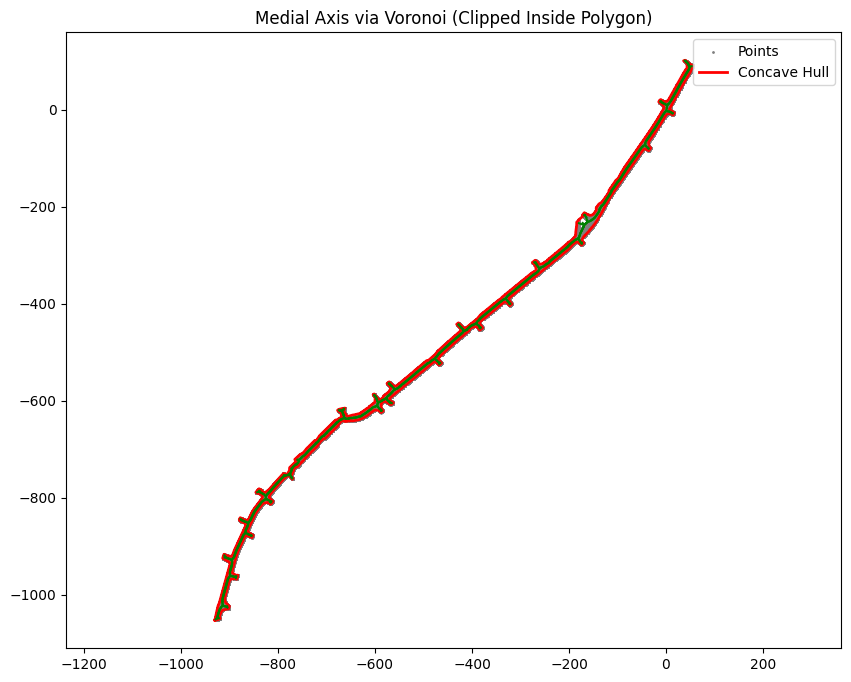

In [8]:
# Visualization
plt.figure(figsize=(10, 8))
# plt.plot(*polygon.exterior.xy, color='black', linewidth=2, label="Polygon")

plt.scatter(points2D[:, 0], points2D[:, 1], s=1, color='gray', label='Points')
plt.plot(nhull[:, 0], nhull[:, 1], 'r-', linewidth=2, label='Concave Hull')

for line in medial_lines:
    x, y = line.xy
    plt.plot(x, y, 'g-')
plt.axis('equal')
plt.title("Medial Axis via Voronoi (Clipped Inside Polygon)")
plt.legend()
plt.show()

In [ ]:
from shapely.ops import linemerge
import os

# ----------------------------------------------------------------------------------------------------||
# <Merge Centerlines and Create Buffered Polygon # ---------------------------------------------------||
# ----------------------------------------------------------------------------------------------------||
# Merge into a single continuous centerline
merged_centerline = linemerge(medial_lines)

# Buffer width (adjust as needed)
roadWidth = 10  # meters (this will buffer ±3.0 m around the centerline)

# Create buffer polygon
roadPolygon = merged_centerline.buffer(roadWidth, cap_style=2, join_style=2)

# If MultiPolygon, keep the largest
if roadPolygon.geom_type == "MultiPolygon":
    roadPolygon = max(roadPolygon.geoms, key=lambda p: p.area)

# ----------------------------------------------------------------------------------------------------||
# <Convert Polygon to PyVista Mesh>
# ----------------------------------------------------------------------------------------------------||
polyPts2D = np.array(roadPolygon.exterior.coords)
polyPts3D = np.hstack([polyPts2D, np.zeros((polyPts2D.shape[0], 1))])

nPts = polyPts3D.shape[0]
faces = np.concatenate([[nPts], np.arange(nPts)])

roadMesh = pv.PolyData(polyPts3D, faces).triangulate()

# ----------------------------------------------------------------------------------------------------||
# <Save Mesh to Disk>
# ----------------------------------------------------------------------------------------------------||
outputDir = "Output"
os.makedirs(outputDir, exist_ok=True)

# Save as PLY
plyPath = f"{outputDir}/{fileName}_road_mesh.ply"
roadMesh.save(plyPath)

In [ ]:
roadMesh.save(f"Output/{fileName}_road_mesh.obj")

/home/gvcl/anaconda3/envs/digTwin/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


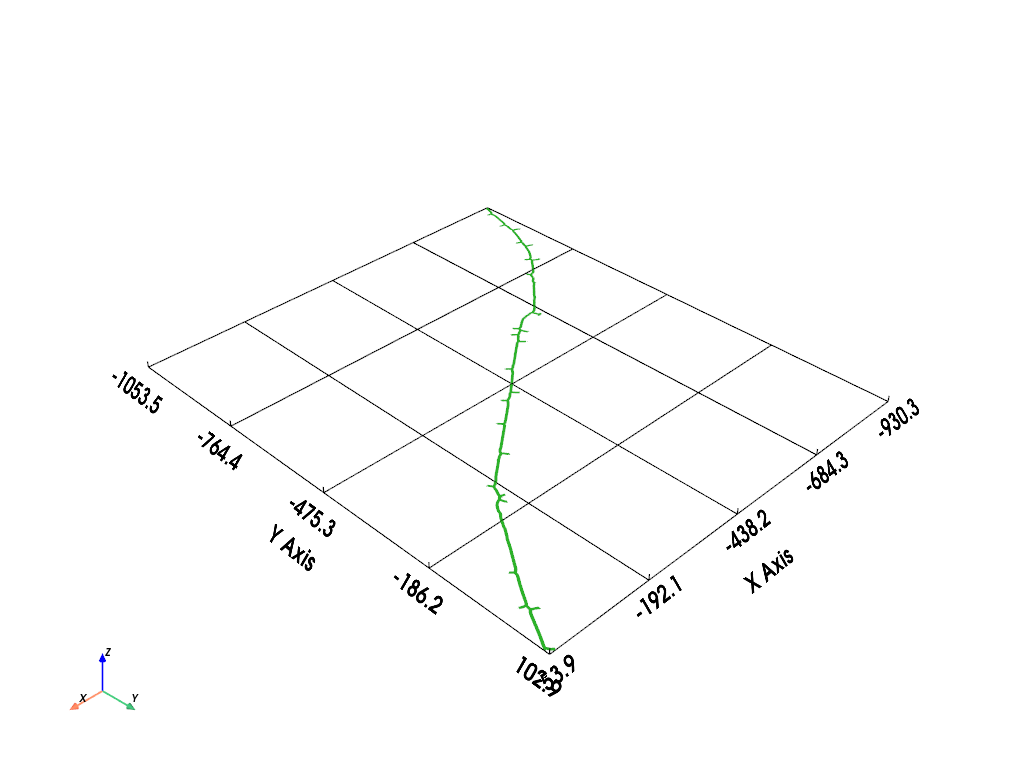

In [11]:
mesh = pv.read(plyPath)

# Set up the plotter
plotter = pv.Plotter(window_size=[1024, 768])
plotter.set_background("white")

# Add mesh to the scene
plotter.add_mesh(mesh, color="limegreen", show_edges=False, smooth_shading=True)

# Add axes and camera controls
plotter.show_bounds(grid="front", location="outer", all_edges=True)
plotter.add_axes()
plotter.show(title="Road Mesh Viewer")

## Constrained mesh generation - Adding z-value as well

In [8]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi
import pickle

# ----------------------------------------------------------------------------------------------------||
# <Load input data>
# ----------------------------------------------------------------------------------------------------||
fileName = "Lille2" #"ParisLille_Combined_Road_Road1" #"Lille2"

points2D = np.load(f"Extraction/{fileName}_points2D.npy")
hull = np.load(f"Extraction/{fileName}_hull.npy", allow_pickle=True)
nhull = np.load(f"Extraction/{fileName}_nhull.npy")

polygon = Polygon(nhull)

In [9]:
with open(f"Extraction/{fileName}_centerlines.pkl", "rb") as f:
        medial_lines = pickle.load(f)

In [10]:
def loadAndProject3DPLY(plyPath):
    cloud = pv.read(plyPath)
    points3D = np.array(cloud.points)
    points3D = np.unique(points3D, axis=0)
    return points3D

plyPath = f"Input/{fileName}.ply"
points3D = loadAndProject3DPLY(plyPath)

In [11]:
medial_lines

[<LINESTRING (-923.071 -1047.859, -924.122 -1047.474)>,
 <LINESTRING (-920.665 -1048.776, -919.619 -1049.103)>,
 <LINESTRING (-925.522 -1048.343, -925.44 -1048.223)>,
 <LINESTRING (-925.44 -1048.223, -925.002 -1047.734)>,
 <LINESTRING (-924.571 -1047.245, -924.122 -1047.474)>,
 <LINESTRING (-924.571 -1047.245, -924.98 -1047.702)>,
 <LINESTRING (-925.002 -1047.734, -924.98 -1047.702)>,
 <LINESTRING (-920.665 -1048.776, -920.763 -1048.703)>,
 <LINESTRING (-921.867 -1048.309, -920.763 -1048.703)>,
 <LINESTRING (-923.071 -1047.859, -923.004 -1047.873)>,
 <LINESTRING (-923.004 -1047.873, -921.944 -1048.262)>,
 <LINESTRING (-921.867 -1048.309, -921.944 -1048.262)>,
 <LINESTRING (-918.337 -1027.402, -918.748 -1028.081)>,
 <LINESTRING (-918.337 -1027.402, -917.751 -1026.583)>,
 <LINESTRING (-917.078 -1025.765, -917.075 -1025.766)>,
 <LINESTRING (-917.751 -1026.583, -917.075 -1025.766)>,
 <LINESTRING (-777.016 -753.715, -777.95 -753.599)>,
 <LINESTRING (-778.889 -753.544, -777.998 -753.608)>,
 

In [14]:
import numpy as np
import pyvista as pv
from shapely.geometry import LineString, Polygon, Point
from shapely.ops import linemerge
from scipy.spatial import cKDTree
import pickle, os

# ----------------------------- Load 3D road point cloud ----------------------------- #
plyPath = f"Input/{fileName}.ply"
cloud = pv.read(plyPath)
points3D = np.array(cloud.points)
pointsXY = points3D[:, :2]

# KDTree for fast nearest neighbor search
tree = cKDTree(pointsXY)

# ----------------------------- Load centerlines ----------------------------- #
with open(f"Extraction/{fileName}_centerlines.pkl", "rb") as f:
    medial_lines = pickle.load(f)

merged_centerline = linemerge(medial_lines)

# ----------------------------- Sample points along centerline ----------------------------- #
num_samples = int(merged_centerline.length)  # 1 point per meter
distances = np.linspace(0, merged_centerline.length, num_samples)
centerline_pts2D = np.array([merged_centerline.interpolate(d).coords[0] for d in distances])

# ----------------------------- Assign Z values ----------------------------- #
radius = 5.0  # meters
centerline_ptsZ = []

for pt in centerline_pts2D:
    idx = tree.query_ball_point(pt, radius)
    if len(idx) > 0:
        z_val = points3D[idx, 2].mean()
    else:
        z_val = 0.0  # fallback if no neighbors
    centerline_ptsZ.append(z_val)

centerline_pts3D = np.hstack([centerline_pts2D, np.array(centerline_ptsZ)[:, None]])

# ----------------------------- Create road buffer polygon ----------------------------- #
roadWidth = 10.0
centerline_line3D = LineString(centerline_pts3D[:, :2])
roadPolygon = centerline_line3D.buffer(roadWidth, cap_style=2, join_style=2)

if roadPolygon.geom_type == "MultiPolygon":
    roadPolygon = max(roadPolygon.geoms, key=lambda p: p.area)

# ----------------------------- Convert to PyVista mesh ----------------------------- #
polyPts2D = np.array(roadPolygon.exterior.coords)

# Assign Z from nearest centerline point
polyPtsZ = []
for xy in polyPts2D:
    dist = np.linalg.norm(centerline_pts2D - xy, axis=1)
    nearest_idx = np.argmin(dist)
    polyPtsZ.append(centerline_pts3D[nearest_idx, 2])
polyPts3D = np.hstack([polyPts2D, np.array(polyPtsZ)[:, None]])

nPts = polyPts3D.shape[0]
faces = np.concatenate([[nPts], np.arange(nPts)])
roadMesh = pv.PolyData(polyPts3D, faces).triangulate()

# ----------------------------- Save mesh ----------------------------- #
outputDir = "Output"
os.makedirs(outputDir, exist_ok=True)
plyPath = f"{outputDir}/{fileName}_road_mesh_3D.ply"
roadMesh.save(plyPath)
